# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


# 1. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload
# Reload all modules (except those excluded by %aimport) automatically now.

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
try:
    assert len(df) > df['encounter_id'].nunique()
    print('Dataset is at line level')
except:
    print('Dataset is not at line level')

Dataset is at line level


In [6]:
df.shape

(143424, 26)

In [7]:
df.encounter_id.nunique()

101766

In [8]:
df.patient_nbr.nunique()

71518

Student Response: This dataset is at line level. Because the total number of rows is greater than the number of unique encounters. Additionally, in my opinion it also necessary to aggregate data on the fields primary_diagnosis_code and time_in_hospital. Because primary_diagnosis_code indicates patient's diseases and our drug needs to be under scrutiny over 5-7 days of time in the hospital.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


In [9]:
def check_missing_values(df):
    null_df = pd.DataFrame({'columns': df.columns,
                            'percent_null': df.isnull().sum()*100/len(df),
#                             'percent_zero': df.isin([0]).sum()*100/len(df),
#                             'percent_none': df.isin(['None']).sum()*100/len(df),
                            'percent_question':df.isin(['?']).sum()*100/len(df),
                            'percent_nan':df.isin(['NaN']).sum()*100/len(df)
                            
        
    })
    return null_df

In [10]:
null_df = check_missing_values(df)

In [11]:
null_df

,columns,percent_null,percent_question,percent_nan
encounter_id,encounter_id,0.00000,0.000000,0.0
patient_nbr,patient_nbr,0.00000,0.000000,0.0
race,race,0.00000,2.307145,0.0
gender,gender,0.00000,0.000000,0.0
age,age,0.00000,0.000000,0.0
weight,weight,0.00000,97.000502,0.0
admission_type_id,admission_type_id,0.00000,0.000000,0.0
discharge_disposition_id,discharge_disposition_id,0.00000,0.000000,0.0
admission_source_id,admission_source_id,0.00000,0.000000,0.0
time_in_hospital,time_in_hospital,0.00000,0.000000,0.0


In [12]:
null_df.sum(axis=1).sort_values(ascending=False)

weight                      97.000502
medical_specialty           48.431922
payer_code                  37.783077
ndc_code                    16.358490
race                         2.307145
primary_diagnosis_code       0.023009
patient_nbr                  0.000000
gender                       0.000000
age                          0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
readmitted                   0.000000
change                       0.000000
other_diagnosis_codes        0.000000
number_outpatient            0.000000
number_inpatient             0.000000
number_emergency             0.000000
num_lab_procedures           0.000000
number_diagnoses             0.000000
num_medications              0.000000
num_procedures               0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
encounter_id                 0.000000
dtype: float

Q2 a.
As shown above, the field Weight has the highest amount of missing/zero values, followed by medical_specialty, payer_code, ndc_code and race. The percentage of missing values in primary_diagnosis_code is the smallest, which is less than 0.03%.


In [13]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [15]:
# identify numerical field
numerical_field_list=[]
for c in df.columns:
    if df[c].dtype == 'int64':
        numerical_field_list.append(c)

In [16]:
numerical_field_list

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

In [17]:
none_num_list=['encounter_id','patient_nbr','admission_type_id','discharge_disposition_id','admission_source_id']

In [18]:
for x in none_num_list:
    numerical_field_list.remove(x)

In [19]:
numerical_field_list

['time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

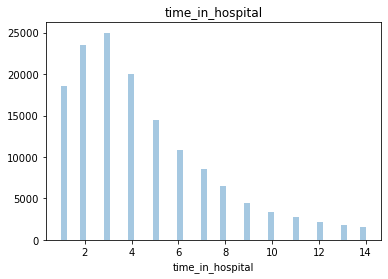

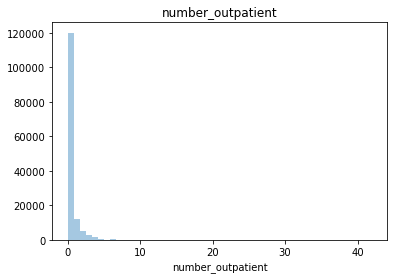

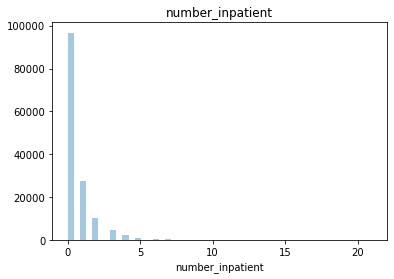

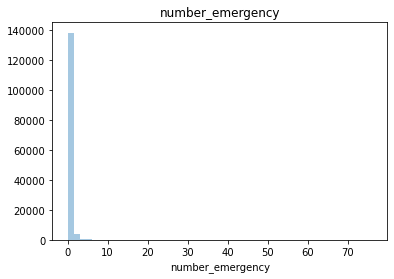

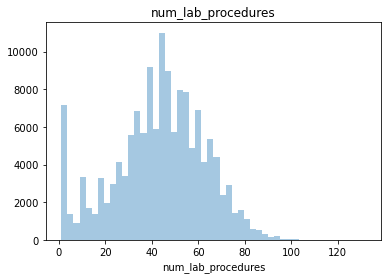

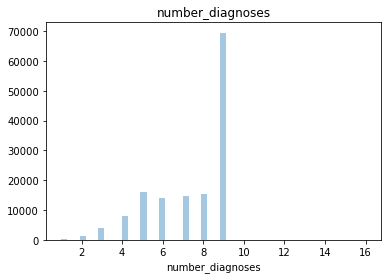

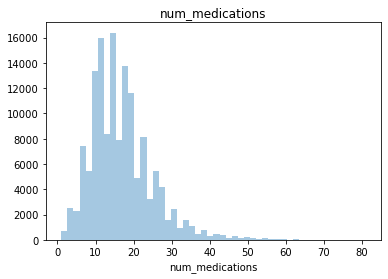

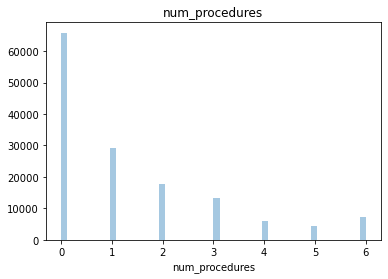

In [20]:
for c in numerical_field_list:
    sns.distplot(df[c], kde=False)
    plt.title(c)
    plt.show()

Q2 b. It seems that the distribution of num_lab_procedures and num_medications are normal distribution.

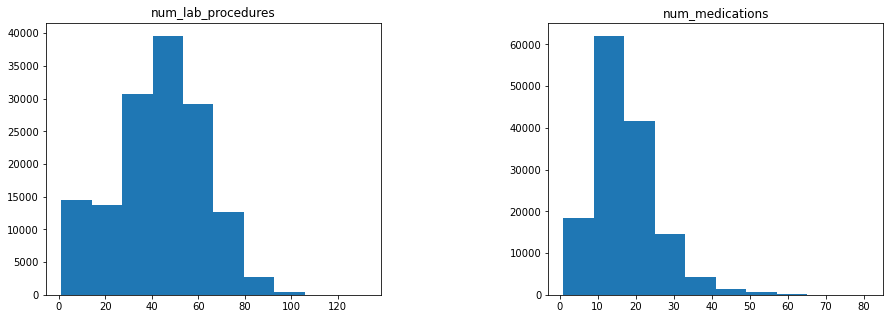

In [21]:
normal_list = ['num_lab_procedures', 'num_medications']
fig, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
for num, val in enumerate(normal_list) :
    axes[num].hist(df.dropna(subset=[val])[val])
    axes[num].title.set_text(val)

In [22]:
# identify categorical field
categorical_field_list=[]
for c in df.columns:
    if df[c].dtype == 'object':
        categorical_field_list.append(c)

In [23]:
categorical_field_list

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted']

In [24]:
for x in none_num_list:
    categorical_field_list.append(x)

In [25]:
categorical_field_list

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted',
 'encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id']

In [26]:
def unique_values(df,c_list):
    card_df = pd.DataFrame({'columns': c_list,
                            'cardinality': df[c_list].nunique()
                            
        
    })
    return card_df

In [27]:
card_df = unique_values(df,categorical_field_list)
card_df.sum(axis=1).sort_values(ascending=False)

encounter_id                101766
patient_nbr                  71518
other_diagnosis_codes        19374
primary_diagnosis_code         717
ndc_code                       251
medical_specialty               73
discharge_disposition_id        26
payer_code                      18
admission_source_id             17
weight                          10
age                             10
admission_type_id                8
race                             6
max_glu_serum                    4
A1Cresult                        4
readmitted                       3
gender                           3
change                           2
dtype: int64

Q2 c. the cardinality of all categorical fields is shown as above. The fields have high cardinality are:

encounter_id                101766

patient_nbr                  71518

other_diagnosis_codes     19374

primary_diagnosis_code      717

ndc_code                    251

medical_specialty            73  

discharge_disposition_id        26

Text(0.5, 1.0, 'Age distribution')

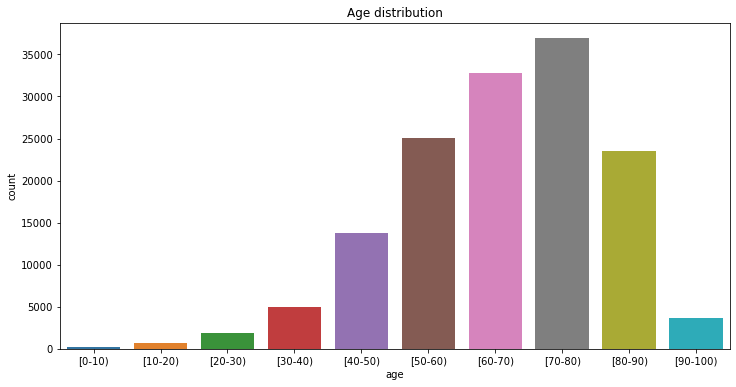

In [28]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="age", data=df)
plt.title('Age distribution')

Text(0.5, 1.0, 'Gender distribution')

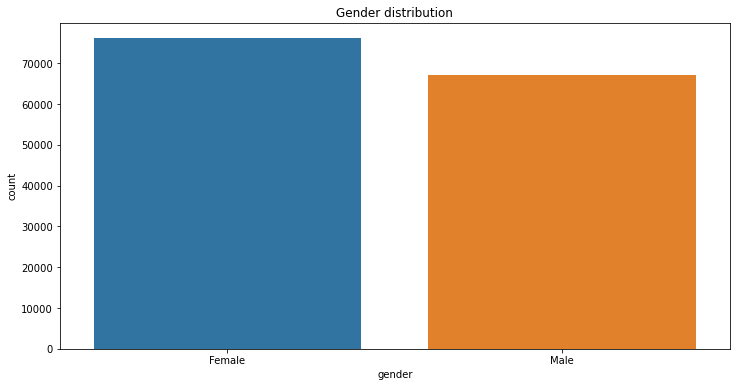

In [29]:
df.drop(df.loc[df['gender']=='Unknown/Invalid'].index, inplace=True)
plt.figure(figsize=(12,6))
ax = sns.countplot(x="gender", data=df)
plt.title('Gender distribution')

Text(0.5, 1.0, 'Age and Gender distribution')

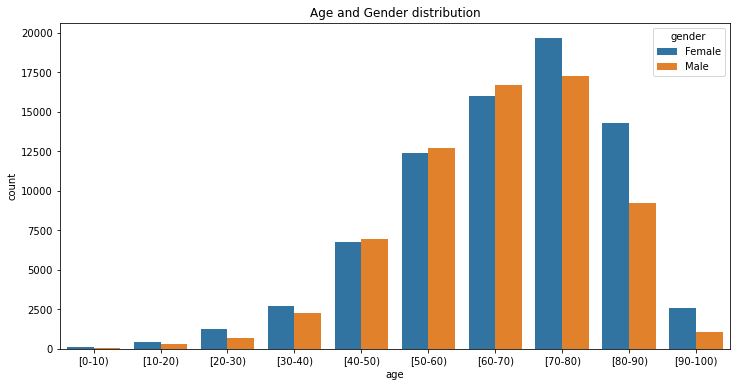

In [30]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="age", hue="gender", data=df)
plt.title('Age and Gender distribution')

Text(0.5, 1.0, 'Race distribution')

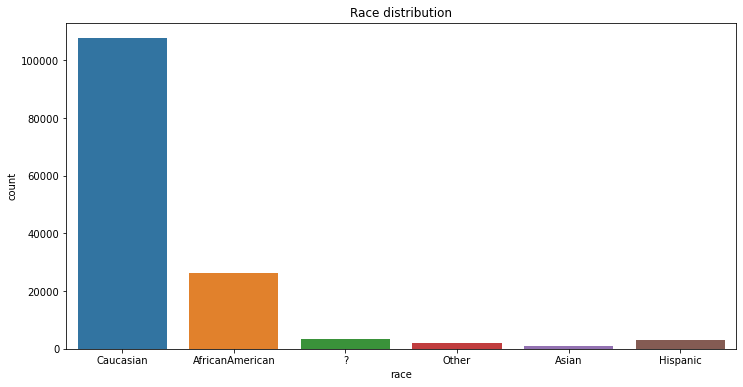

In [31]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="race", data=df)
plt.title('Race distribution')

Text(0.5, 1.0, 'Race and Gender distribution')

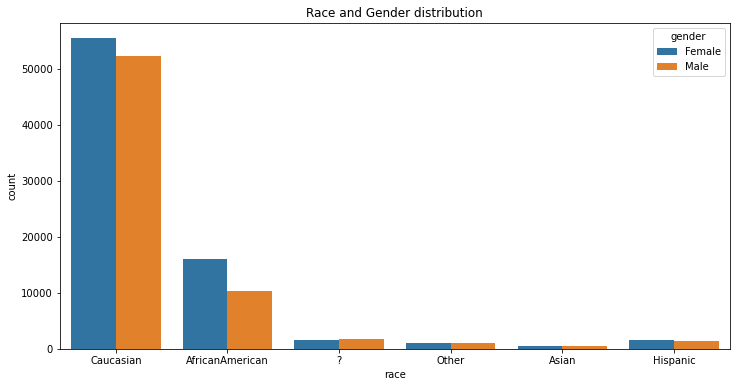

In [32]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="race", hue="gender", data=df)
plt.title('Race and Gender distribution')

Text(0.5, 1.0, 'Race and Age distribution')

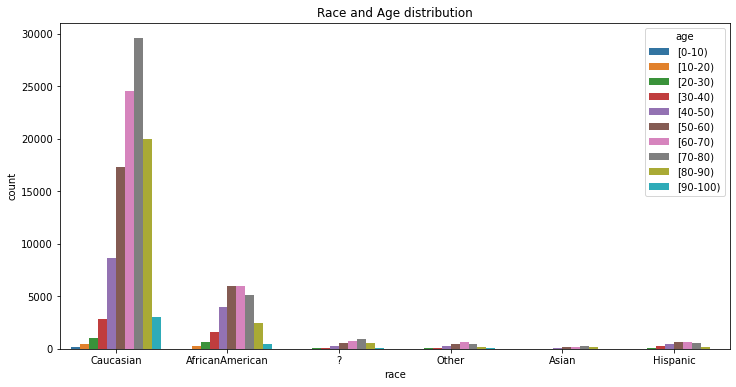

In [33]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="race", hue="age", data=df)
plt.title('Race and Age distribution')

Q2 d. As figures shown above, most patients are in the age of 30 to 90 years old. The number of female patient is a little bit greater than of male (about 10000). The distribution of male and female patients of different age are about the same. The number of male patients in age of 40 to 70 is more than of female. There are more female patients than men in other age groups.

The most patients are caucasian. It means that the model based on this dataset is more reliable to detect the result for caucasian. The gender distribution for all races is almost the same. Except the unknown race，there are more females than males for other races. The shape of the age distribution of all races is almost normal. The most patients are over 50 years old.

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [34]:
######NOTE: The visualization will only display in Chrome browser. ########
# import tensorflow_data_validation as tfdv
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [35]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [36]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [37]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [38]:
missing_value_column = ['weight', 'medical_specialty', 'payer_code' ]

In [39]:
df_new = df.drop(columns=missing_value_column)
df_new.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [40]:
from student_utils import reduce_dimension_ndc

In [41]:
reduce_dim_df = reduce_dimension_ndc(df_new, ndc_code_df)
reduce_dim_df

/home/workspace/starter_code/student_utils.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndc_df_1['ndc_code'] = ndc_df_1['NDC_Code']


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143472,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,Insulin Human
143473,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,Glipizide
143474,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,Pioglitazone
143475,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,Insulin Human


In [42]:
# Number of unique values should be less for the new output field
assert df_new['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [43]:
df_new['ndc_code'].nunique()

251

In [44]:
reduce_dim_df['generic_drug_name'].nunique()

22

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [45]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [46]:
first_encounter_df

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,42291-559,None,None,Ch,<30,Metformin Hydrochloride
1,378,29758806,Caucasian,Female,[50-60),3,1,1,2,722,305|250,0,0,0,49,3,11,1,NaN,None,None,No,NO,NaN
2,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,0615-7982,None,>7,No,NO,Metformin Hydrochloride
3,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,0378-7185,None,>8,Ch,NO,Metformin Hydrochloride
4,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,42571-104,None,None,No,NO,Glimepiride
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71510,189351095,418513058,Caucasian,Female,[80-90),1,1,7,1,285,401|496,0,0,0,73,9,11,1,NaN,None,None,No,NO,NaN
71511,189365864,359719064,Other,Male,[60-70),1,1,7,3,584,250.02|403,0,0,0,56,7,8,1,68071-1701,None,None,No,NO,Human Insulin
71512,189445127,338462954,Caucasian,Female,[80-90),1,1,7,3,486,414|733,0,0,0,39,9,18,0,42291-582,None,None,Ch,NO,Metformin Hydrochloride
71513,189481478,443811536,Caucasian,Female,[40-50),1,4,7,14,295,305|250,0,0,0,69,5,16,0,42385-902,None,>7,Ch,>30,Metformin Hydrochloride


In [47]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71515
Number of unique encounters:71515
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [48]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [49]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,42291-559,None,None,Ch,<30,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,729,189899286,Caucasian,Female,[80-90),1,3,7,4,820,493|E880,0,0,0,68,9,23,2,0615-7982,None,>7,No,NO,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,774,64331490,Caucasian,Female,[80-90),1,1,7,3,274,427|416,0,0,0,46,9,20,0,0378-7185,None,>8,Ch,NO,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,927,14824206,AfricanAmerican,Female,[30-40),1,1,7,5,590,220|250,0,0,0,49,3,5,0,42571-104,None,None,No,NO,[Glimepiride],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1152,8380170,AfricanAmerican,Female,[50-60),1,1,7,6,282,250.01|?,0,1,0,43,2,13,2,47918-902,None,None,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [50]:
agg_drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56131 entries, 0 to 56130
Data columns (total 44 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   patient_nbr                                 56131 non-null  int64 
 1   encounter_id                                56131 non-null  int64 
 2   race                                        56131 non-null  object
 3   gender                                      56131 non-null  object
 4   age                                         56131 non-null  object
 5   admission_type_id                           56131 non-null  int64 
 6   discharge_disposition_id                    56131 non-null  int64 
 7   admission_source_id                         56131 non-null  int64 
 8   time_in_hospital                            56131 non-null  int64 
 9   primary_diagnosis_code                      56131 non-null  object
 10  other_diagnosis_codes 

In [51]:
agg_drug_df['patient_nbr'].nunique()

56131

In [52]:
agg_drug_df['encounter_id'].nunique()

56131

In [53]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: ??

The field weight has a huge amount of missing values(more than 97%). And the payer_code field has also too many missing values which are greater than 37%. And they have nothing to do with the duration of time in hospital. So I think they should not be included. 

In [54]:
null_df.sum(axis=1).sort_values(ascending=False)

weight                      97.000502
medical_specialty           48.431922
payer_code                  37.783077
ndc_code                    16.358490
race                         2.307145
primary_diagnosis_code       0.023009
patient_nbr                  0.000000
gender                       0.000000
age                          0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
readmitted                   0.000000
change                       0.000000
other_diagnosis_codes        0.000000
number_outpatient            0.000000
number_inpatient             0.000000
number_emergency             0.000000
num_lab_procedures           0.000000
number_diagnoses             0.000000
num_medications              0.000000
num_procedures               0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
encounter_id                 0.000000
dtype: float

In [55]:
agg_drug_df.columns

Index(['patient_nbr', 'encounter_id', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'primary_diagnosis_code', 'other_diagnosis_codes',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures', 'ndc_code', 'max_glu_serum', 'A1Cresult', 'change',
       'readmitted', 'generic_drug_name_array', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl',
       'Glipizide_And_Metformin_Hydrochloride', 'Glyburide',
       'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide'],
      dtype='object')

In [56]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ['ndc_code', 'primary_diagnosis_code'] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['num_lab_procedures', 'number_diagnoses', 'num_medications']
PREDICTOR_FIELD = 'time_in_hospital'

In [57]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [58]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [59]:
selected_features_df.columns

Index(['patient_nbr', 'time_in_hospital', 'ndc_code', 'primary_diagnosis_code',
       'race', 'gender', 'age', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride',
       'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'number_diagnoses', 'num_medications'],
      dtype='object')

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [60]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [61]:
processed_df

,patient_nbr,time_in_hospital,ndc_code,primary_diagnosis_code,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,number_diagnoses,num_medications
0,135,8.0,42291-559,401,Caucasian,Female,[50-60),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,77,8,33
1,729,4.0,0615-7982,820,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,68,9,23
2,774,3.0,0378-7185,274,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,46,9,20
3,927,5.0,42571-104,590,AfricanAmerican,Female,[30-40),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,3,5
4,1152,6.0,47918-902,282,AfricanAmerican,Female,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,43,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56126,189349430,1.0,43063-630,595,Asian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,9,6
56127,189365864,3.0,68071-1701,584,Other,Male,[60-70),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,56,7,8
56128,189445127,3.0,42291-582,486,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,39,9,18
56129,189481478,14.0,42385-902,295,Caucasian,Female,[40-50),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,69,5,16


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [62]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Total number of unique patients in train =  33679
Total number of unique patients in validation =  11226
Total number of unique patients in test =  11226
Total number of three partitions =  56131


In [63]:
len(processed_df)

56131

In [64]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [65]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      7693
2.0      9526
3.0     10065
4.0      7666
5.0      5518
6.0      4095
7.0      3224
8.0      2375
9.0      1643
10.0     1276
11.0     1030
12.0      798
13.0      671
14.0      551
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


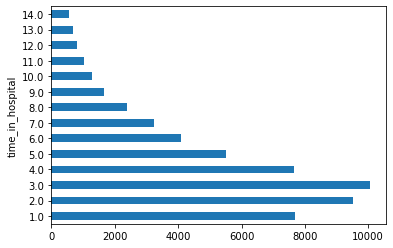

In [66]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4653
2.0     5644
3.0     6065
4.0     4571
5.0     3303
6.0     2461
7.0     1923
8.0     1432
9.0     1005
10.0     810
11.0     600
12.0     496
13.0     387
14.0     329
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


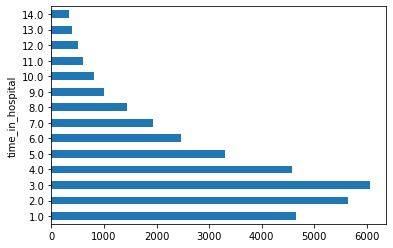

In [67]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1542
2.0     1987
3.0     1999
4.0     1532
5.0     1055
6.0      828
7.0      664
8.0      467
9.0      329
10.0     223
11.0     206
12.0     156
13.0     134
14.0     104
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


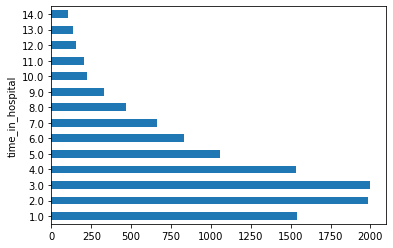

In [68]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    29583
Male      26548
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


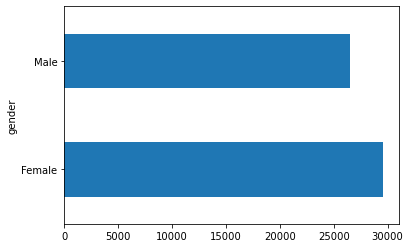

In [69]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17741
Male      15938
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


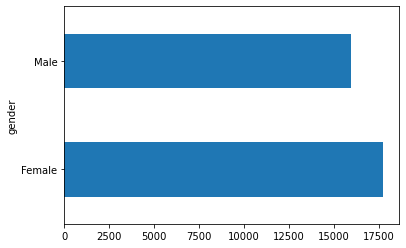

In [70]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5926
Male      5300
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


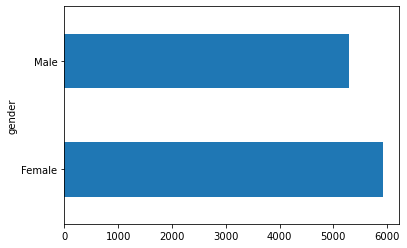

In [71]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [72]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [73]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [74]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [75]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 237 in ndc_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/ndc_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 601 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in Glimepiride is inferred from the number of elements in the voc

In [76]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='ndc_code', vocabulary_file='./diabetes_vocab/ndc_code_vocab.txt', vocabulary_size=237, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 238), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [77]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [78]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [79]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [80]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fbaf2f750e0>, mean=43.54868018646634, std=20.096583657640476))

tf.Tensor(
[[-0.55]
 [ 0.3 ]
 [-1.15]
 [-0.05]
 [-1.25]
 [ 1.  ]
 [-0.85]
 [ 0.75]
 [-2.1 ]
 [-0.6 ]
 [ 0.65]
 [-0.45]
 [ 0.45]
 [ 0.9 ]
 [ 0.1 ]
 [-2.  ]
 [ 0.  ]
 [-0.55]
 [ 0.2 ]
 [ 1.2 ]
 [ 0.3 ]
 [-0.1 ]
 [ 0.7 ]
 [-0.15]
 [ 0.2 ]
 [-0.85]
 [ 0.  ]
 [-0.45]
 [-1.  ]
 [ 0.8 ]
 [ 0.35]
 [ 1.  ]
 [ 0.5 ]
 [ 0.7 ]
 [ 0.6 ]
 [ 0.5 ]
 [-0.45]
 [ 1.55]
 [ 0.55]
 [-0.3 ]
 [ 0.15]
 [ 0.45]
 [ 2.1 ]
 [-1.  ]
 [ 0.25]
 [-0.75]
 [-1.25]
 [-0.35]
 [-2.1 ]
 [ 0.8 ]
 [-0.4 ]
 [ 0.7 ]
 [ 0.  ]
 [-2.1 ]
 [-0.55]
 [ 0.65]
 [ 1.15]
 [-2.1 ]
 [-0.7 ]
 [-0.05]
 [-2.1 ]
 [ 0.3 ]
 [ 0.1 ]
 [-1.55]
 [-1.3 ]
 [ 1.  ]
 [-1.65]
 [ 0.3 ]
 [ 1.3 ]
 [ 0.  ]
 [-0.85]
 [-0.25]
 [ 1.05]
 [-2.1 ]
 [ 0.65]
 [ 0.85]
 [ 0.1 ]
 [ 0.35]
 [ 0.15]
 [-0.6 ]
 [ 1.8 ]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [81]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [82]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [83]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=100)

Train for 264 steps, validate for 88 steps
Epoch 1/100
264/264 [==============================] - 7s 28ms/step - loss: 28.6792 - mse: 28.5659 - val_loss: 20.4961 - val_mse: 20.1315
Epoch 2/100
264/264 [==============================] - 4s 15ms/step - loss: 19.0838 - mse: 18.5961 - val_loss: 16.8303 - val_mse: 15.9985
Epoch 3/100
264/264 [==============================] - 4s 15ms/step - loss: 14.7289 - mse: 14.0877 - val_loss: 14.8534 - val_mse: 14.0915
Epoch 4/100
264/264 [==============================] - 4s 15ms/step - loss: 12.7885 - mse: 11.7658 - val_loss: 12.5565 - val_mse: 11.7079
Epoch 5/100
264/264 [==============================] - 4s 16ms/step - loss: 11.7822 - mse: 10.9288 - val_loss: 12.0087 - val_mse: 11.3468
Epoch 6/100
264/264 [==============================] - 4s 16ms/step - loss: 11.2305 - mse: 10.3676 - val_loss: 10.2043 - val_mse: 9.0767
Epoch 7/100
264/264 [==============================] - 4s 16ms/step - loss: 10.4468 - mse: 9.5865 - val_loss: 10.3240 - val_mse: 9

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [84]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [85]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [86]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [87]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,3.804437,4.0,3.697170,0.699212
1,7.567168,3.0,6.250283,0.704912
2,3.046335,4.0,4.951562,0.701480
3,4.655117,8.0,4.249111,0.698557
4,4.565629,5.0,5.267164,0.703798


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [88]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [89]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [90]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,837414,Male,AfricanAmerican,4.0,0,0
1,90484776,Female,Caucasian,3.0,1,0
2,44291070,Female,Caucasian,4.0,0,0
3,23837742,Female,Caucasian,8.0,0,1
4,125294423,Female,Caucasian,5.0,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [91]:
from sklearn.metrics import  precision_recall_curve, accuracy_score, f1_score, plot_precision_recall_curve, classification_report, roc_auc_score, roc_curve,recall_score, precision_score,average_precision_score

In [92]:
print('AUC Score: ', roc_auc_score(pred_test_df['label_value'], pred_test_df['score']))
print('F1 Score: ', f1_score(pred_test_df['label_value'], pred_test_df['score']))
print('Precision Score: ', precision_score(pred_test_df['label_value'], pred_test_df['score']))
print('Recall Score: ', recall_score(pred_test_df['label_value'], pred_test_df['score']))


AUC Score:  0.6785358745217932
F1 Score:  0.5509788566953798
Precision Score:  0.7926994141505183
Recall Score:  0.42222755640902543


In [93]:
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82      7060
           1       0.79      0.42      0.55      4166

    accuracy                           0.74     11226
   macro avg       0.76      0.68      0.69     11226
weighted avg       0.76      0.74      0.72     11226



In [94]:
def plot_precision_recall_curve(ground_truth, probability):
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
    ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Patient Selection', average_precision_score(ground_truth, probability)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    pass

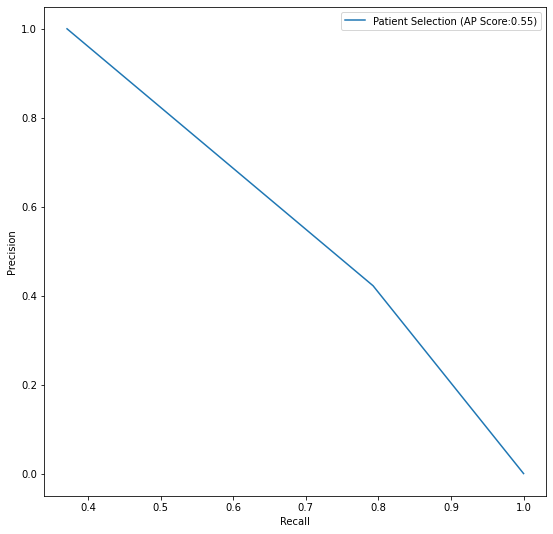

In [95]:
plot_precision_recall_curve(pred_test_df['label_value'],pred_test_df['score'])

Text(0.5, 1.0, 'The value of Precision/Recall with different threshold')

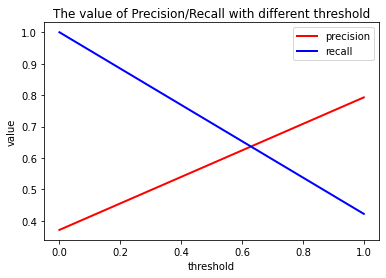

In [96]:
precision, recall, thresholds = precision_recall_curve(pred_test_df['label_value'],pred_test_df['score'])
plt.plot(thresholds, precision[:-1], color='red', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='blue', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('The value of Precision/Recall with different threshold')

As shown above, the value of precision and recall are different for different thresholds. High precision relates to a low false positive rate while high recall relates to a low false negative rate. For our case time_in_hospital>5 is positive. A high recall model is good to detect a patient who doesn't have diseases，which is equivalent to confirm the hospitalization time less than 5 days. A high precision model is more reliable to confirm the hospitalization time more than 5 days.

Our purpose of this project is administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. Therefore, it is not necessary to monitor patients who have been hospitalized for less than 5 days. Because of this, high precision is more suitable for us.

Review:
Recall specifies the actual fraction of items correctly retrieved. The goal of this exercise was to identify patients that are going to spend more than 5 days in the hospital. So, a model that identifies more of these patients is valuable to us. At the same time, it should not give us a lot of false positives. If you look at the model's classification report, it has a recall of only 45% for the positive class (more than 5 days in hospital). This means that if we have 100 patients that are actually going to spend more than 5 days in the hospital, our model will only be able to identify 45 of them. So, if we have a large pool of patients and we need only a handful for ou study, this model might work. However, if we do not have enough patients to begin with, this model might not be able to give us the required number of patients for our study.



# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [97]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [2219]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [98]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

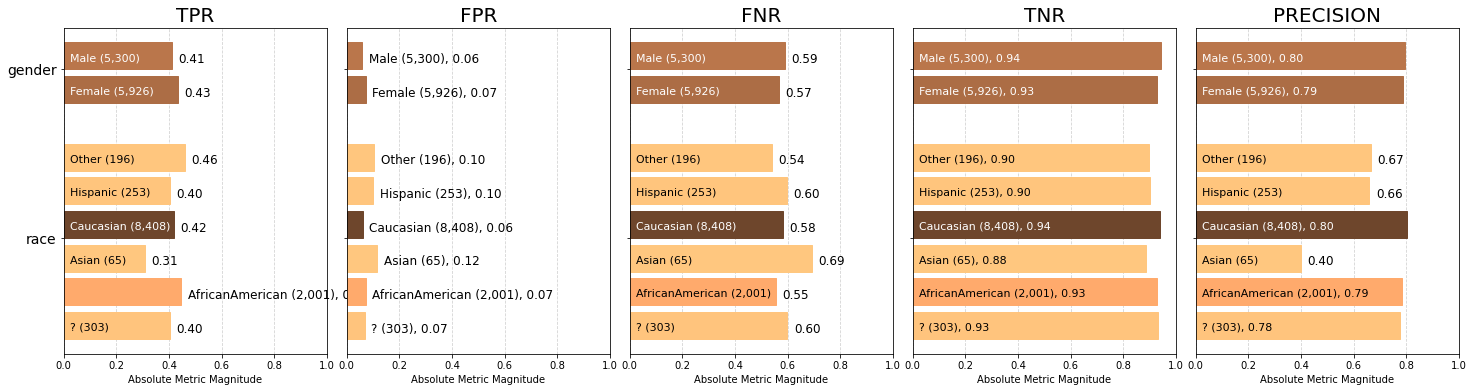

In [99]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'fnr', 'tnr', 'precision'], ncols=5)

As figures above shows, there is no significant bias in the model across any of the groups. Caucasian has the highest precision and shows lowest FPR among all races.


## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

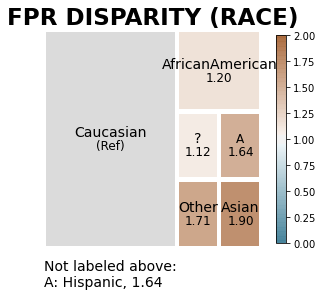

In [100]:
# Reference group fairness plot

fpr_disparity = aqp.plot_disparity(fdf, group_metric='fpr', 
                                       attribute_name='race')

The FPR disparity of other races is more than 1. This means all other races are more likely to be falsely identified relative to Caucasian.

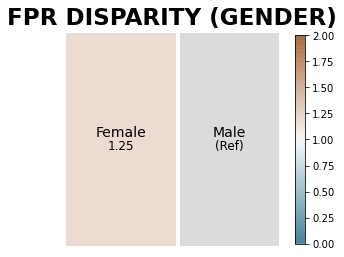

In [101]:
fpr_disparity = aqp.plot_disparity(fdf, group_metric='fpr', 
                                       attribute_name='gender')

The FPR disparity of females is 1.25, which is 25% higer relative to males. This means females are more likely to be falsely identified. 


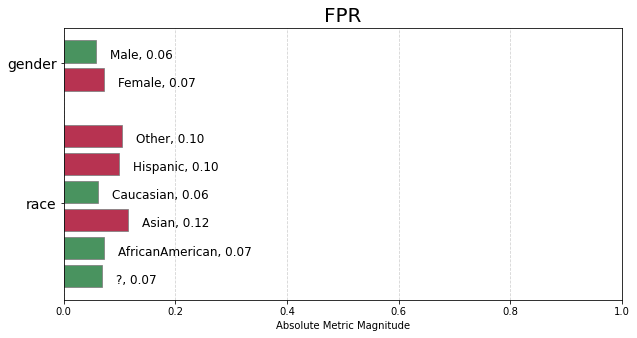

In [102]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)